In [6]:
%matplotlib inline
import utils; reload(utils)
from utils import *

In [17]:
x = random((30, 2))

In [18]:
y = np.dot(x, [2., 3.]) + 1

In [19]:
x[:5]

array([[ 0.8848,  0.2852],
       [ 0.6437,  0.6755],
       [ 0.1613,  0.7991],
       [ 0.5439,  0.547 ],
       [ 0.4778,  0.315 ]])

In [20]:
y[:5]

array([ 3.6252,  4.314 ,  3.7199,  3.7289,  2.9006])

In [9]:
y.shape

(30,)

In [21]:
lm = Sequential([Dense(1, input_shape=(2,))])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

In [22]:
lm.evaluate(x, y, verbose=0)

11.903435707092285

In [31]:
lm.fit(x, y, nb_epoch=5, batch_size=5)

Epoch 1/5
30/30 [==============================] - 0s - loss: 0.0079     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.0072     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0070     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0065     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0062     


In [32]:
lm.evaluate(x, y, verbose=0)

0.0055373446084558964

In [33]:
lm.get_weights()

[array([[ 1.7442],
        [ 2.7589]], dtype=float32), array([ 1.2581], dtype=float32)]

In [49]:
path = 'data/dogscats/sample/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [50]:
batch_size=100

In [2]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [52]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches=get_batches(path+'train', shuffle=False, batch_size=1)

Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [53]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [54]:
val_data = get_data(path+'valid')

Found 8 images belonging to 2 classes.


In [55]:
trn_data = get_data(path+'train')

Found 16 images belonging to 2 classes.


In [56]:
trn_data.shape

(16, 3, 224, 224)

In [57]:
save_array(model_path + 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

In [58]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [59]:
val_data.shape

(8, 3, 224, 224)

In [60]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [61]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [62]:
trn_labels.shape

(16, 2)

In [63]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [64]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [65]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [66]:
trn_features.shape

(16, 1000)

In [69]:
save_array(model_path + 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

In [70]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [71]:
lm = Sequential([Dense(2, activation='softmax', input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
batch_size=4

In [73]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 16 samples, validate on 8 samples
Epoch 1/3
16/16 [==============================] - 0s - loss: 0.6199 - acc: 0.5625 - val_loss: 0.3971 - val_acc: 0.8750
Epoch 2/3
16/16 [==============================] - 0s - loss: 0.3502 - acc: 0.9375 - val_loss: 0.3584 - val_acc: 0.7500
Epoch 3/3
16/16 [==============================] - 0s - loss: 0.2513 - acc: 0.9375 - val_loss: 0.3423 - val_acc: 0.7500


In [74]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_10 (Dense)                 (None, 2)             2002        dense_input_4[0][0]              
Total params: 2002
____________________________________________________________________________________________________


In [75]:
preds = lm.predict_classes(val_features, batch_size=batch_size)
probs = lm.predict_proba(val_features, batch_size=batch_size)[:, 0]
probs[:8]

4/8 [==============>...............] - ETA: 0s

array([ 0.8652,  0.8973,  0.4636,  0.8987,  0.2062,  0.0606,  0.5404,  0.4166], dtype=float32)

In [76]:
filenames = val_batches.filenames

In [77]:
n_view = 4

In [78]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

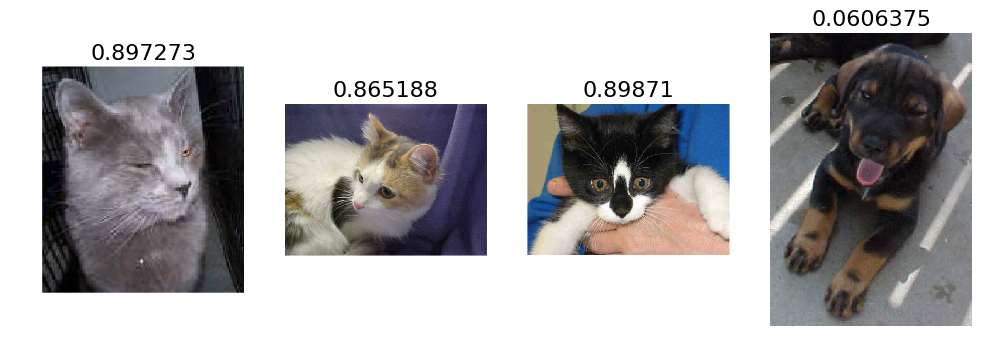

In [79]:
correct = np.where(preds ==val_labels[:, 1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

In [3]:
model.pop()

In [4]:
for layer in model.layers: layer.trainable = False

In [7]:
model.add(Dense(2, activation='softmax'))

In [ ]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, )